In [2]:
import h5py

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# models
MODEL_PATH = '/home/ankbzpx/Documents/'

discrete_encoder_path = MODEL_PATH + 'discrete continuous shape/discrete_encoder_model_256.pth'
discrete_decoder_path = MODEL_PATH + 'discrete continuous shape/discrete_decoder_model_256.pth'
unet_path = MODEL_PATH + 'discrete continuous shape/unet.pth'
continuous_model_path = MODEL_PATH + 'discrete continuous shape/continuous_model.pth'
mapping_path = MODEL_PATH + 'discrete continuous shape/mapping_256.pth'

hidden_dim_discrete = 128

# data preparation
data_file = '/home/ankbzpx/datasets/ShapeNet/ShapeNetRenderingh5_v1/03001627/sdf_train_core.h5'
sample_size = 2048
batch_size = 48
split_ratio = 0.9
depth_size = 256
num_of_workers = 12
# training
num_epoch = 5
start_epoch = 0

In [5]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.autograd import Variable
from PIL import Image
import sys
import time
import matplotlib.pyplot as plt
from torchsummary import summary

In [6]:
# reproducible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)
np.random.seed(0)

In [7]:
device

device(type='cuda')

In [7]:
class ChairSDFDataset(Dataset):
     
    def __init__(self, h5_file):
        
        self.file_path = h5_file
        self.dataset = None
        
        with h5py.File(self.file_path, 'r') as file:
            self.dataset_len = len(file)
            self.keys = list(file.keys())
            
        self.to_tensor = transforms.ToTensor()
     
    def __len__(self):
        return self.dataset_len
 
    def __getitem__(self, idx):
        
        #start_time = time.time()
        
        if self.dataset is None:
            self.dataset = h5py.File(self.file_path, 'r')
         
        group = self.dataset[self.keys[idx]]
        
        raw_depth_img = self.to_tensor(Image.fromarray(np.array(group['depth_img'])))
        
        depth_img = nn.functional.interpolate(raw_depth_img.unsqueeze(0), size=depth_size, mode='nearest').squeeze(0)
        
        
        #print("--- depth preprocessing %s seconds ---" % (time.time() - start_time))
        
        sample_pt_np = np.array(group['sample_pt']).reshape(-1, 3)
        sample_sdf_np = np.array(group['sample_sdf']).reshape(-1, 1)
        
        # check size correctness and fix incorrect data
        if sample_pt_np.shape[0] != 2048:
            sample_pt_np = np.pad(sample_pt_np, ((0, 2048 - sample_pt_np.shape[0]), (0, 0)), 'reflect')
        if sample_sdf_np.shape[0] != 2048:
            sample_sdf_np = np.pad(sample_sdf_np, ((0, 2048 - sample_sdf_np.shape[0]), (0, 0)), 'reflect')
            
        
        sample_pt = torch.from_numpy(sample_pt_np).float()
        sample_sdf = torch.from_numpy(sample_sdf_np).float()
        # scale sdf
        sample_sdf = torch.sign(sample_sdf)*torch.pow(torch.abs(sample_sdf), 0.25)
        
        #print("--- subsampling %s seconds ---" % (time.time() - start_time))
        
        target_vox = torch.from_numpy(np.array(group['target_vox'])).float()
        
        sample = { 'depth_img': depth_img,
                   'sample_pt':sample_pt,
                   'sample_sdf':sample_sdf,
                   'target_vox':target_vox,
                  }
        
        return sample

In [8]:
from vis_utils import plotFromVoxels, plotImg

In [9]:
train_sdf_dataset = ChairSDFDataset(data_file)

In [10]:
len(train_sdf_dataset)

84288

In [11]:
# advanced indexing 2x2x2 context from voxel
def getContext(sample_pt_query, vox):
    
    # sample_pt bxmx3
    # vox bxcxdimxdimxdim
    
    channel_size = vox.shape[1]
    batch_size, sample_size, _ = sample_pt_query.shape
    meshgrid_base = torch.Tensor(np.meshgrid(np.arange(0, batch_size), np.arange(0, channel_size), np.arange(0, 2), np.arange(0, 2), np.arange(0, 2))).int()
    context = torch.empty((batch_size, sample_size, channel_size, 2, 2, 2))

    for j in range(context.shape[1]):
        context[:, j, :, :, :, :] = vox[
                    meshgrid_base[0].long(),
                    meshgrid_base[1].long(),
                    (meshgrid_base[2] + sample_pt_query[:, j, 0].reshape(1, -1, 1, 1, 1)).long(), 
                    (meshgrid_base[3] + sample_pt_query[:, j, 1].reshape(1, -1, 1, 1, 1)).long(), 
                    (meshgrid_base[4] + sample_pt_query[:, j, 2].reshape(1, -1, 1, 1, 1)).long()
                ].transpose(0, 1)
    
    # b x c x m x 2 x 2 x 2
    return context.transpose(1, 2)

In [12]:
def trilinearInterpolation(context, dx, dy, dz):
    
    v0 = context[:, :, :, 0, 0, 0]*(1-dx)*(1-dy)*(1-dz)
    v1 = context[:, :, :, 1, 0, 0]*dx*(1-dy)*(1-dz)
    v2 = context[:, :, :, 0, 1, 0]*(1-dx)*dy*(1-dz)
    v3 = context[:, :, :, 1, 1, 0]*dx*dy*(1-dz)
    v4 = context[:, :, :, 0, 0, 1]*(1-dx)*(1-dy)*dz
    v5 = context[:, :, :, 1, 0, 1]*dx*(1-dy)*dz
    v6 = context[:, :, :, 0, 1, 1]*(1-dx)*dy*dz
    v7 = context[:, :, :, 1, 1, 1]*dx*dy*dz
    
    # b x c x m 1
    return v0 + v1 + v2 + v3 + v4 + v5 + v6 + v7

In [8]:
start_epoch = 0
latent_dim = 256

from models import Discrete_encoder, Mapping, Discrete_decoder, UNET, Continuous

####################
# Discrete Encoder #
####################

discrete_encoder = Discrete_encoder(256).to(device)
discrete_encoder.load_state_dict(torch.load(discrete_encoder_path))
discrete_encoder.eval()

for child in discrete_encoder.children():
    for param in child.parameters():
        param.requires_grad = False


###########
# Mapping #
###########
        
mapping = Mapping(256).to(device)
mapping.load_state_dict(torch.load(mapping_path))
e = mapping.eval()

for child in mapping.children():
    for param in child.parameters():
        param.requires_grad = False
        
####################
# Discrete Decoder #
####################
        
discrete_decoder = Discrete_decoder(256).to(device)
discrete_decoder.load_state_dict(torch.load(discrete_decoder_path))
discrete_decoder.eval()

for child in discrete_decoder.children():
    for param in child.parameters():
        param.requires_grad = False
        
########
# UNET #
########

# pre-trained model is loaded within the model
unet = UNET(unet_path).to(device)

unet.eval()

for child in unet.children():
    for param in child.parameters():
        param.requires_grad = False

##############
# Continuous #
##############

continuous = Continuous().to(device)
continuous.load_state_dict(torch.load(continuous_model_path))

continuous.eval()

for child in continuous.children():
    for param in child.parameters():
        param.requires_grad = False

In [57]:
class Conditional_UNET_FULL(nn.Module):
    def __init__(self, channel_size = 16):
        super(Conditional_UNET_FULL, self).__init__()
        
        self.channel = channel_size
        
        self.down1 = nn.Sequential(
            nn.Conv3d(in_channels = 1, out_channels = self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = self.channel, out_channels = 2*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(2*channel_size),
            nn.ReLU(),
        )
        
        self.down2 = nn.Sequential(
            nn.MaxPool3d(2, 2),
            nn.Conv3d(in_channels = 2*self.channel, out_channels = 2*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(2*self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = 2*self.channel, out_channels = 4*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(4*self.channel),
            nn.ReLU(),
        )
        
        self.down3 = nn.Sequential(
            nn.MaxPool3d(2, 2),
            nn.Conv3d(in_channels = 4*self.channel, out_channels = 4*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(4*self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = 4*self.channel, out_channels = 8*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(8*self.channel),
            nn.ReLU(),
        )
        
        self.down4 = nn.Sequential(
            nn.MaxPool3d(2, 2),
            nn.Conv3d(in_channels = 8*self.channel, out_channels = 8*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(8*self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = 8*self.channel, out_channels = 16*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(16*self.channel),
            nn.ReLU(),
            #nn.Upsample(scale_factor=2, mode='nearest'),
        )
        
        self.down5 = nn.Sequential(
            nn.MaxPool3d(2, 2),
            nn.Conv3d(in_channels = 16*self.channel, out_channels = 16*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(16*self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = 16*self.channel, out_channels = 16*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(16*self.channel),
            nn.ReLU(),
            #nn.Upsample(scale_factor=2, mode='nearest'),
        )        

        self.down6 = nn.Sequential(
            nn.MaxPool3d(2, 2),
            nn.Conv3d(in_channels = 16*self.channel, out_channels = 16*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(16*self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = 16*self.channel, out_channels = 16*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(16*self.channel),
            nn.ReLU(),
            #nn.Upsample(scale_factor=2, mode='nearest'),
        )
        
        
        self.up1 = nn.Sequential(
            nn.Conv3d(in_channels = (16 + 16)*self.channel, out_channels = 16*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(16*self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = 16*self.channel, out_channels = 16*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(8*self.channel),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
        )
        
        self.up2 = nn.Sequential(
            nn.Conv3d(in_channels = (16 + 16)*self.channel, out_channels = 16*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(16*self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = 16*self.channel, out_channels = 16*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(16*self.channel),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
        )
        
        self.up3 = nn.Sequential(
            nn.Conv3d(in_channels = (16 + 16)*self.channel, out_channels = 16*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(8*self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = 16*self.channel, out_channels = 16*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(16*self.channel),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
        )
        
        self.up4 = nn.Sequential(
            nn.Conv3d(in_channels = (16 + 8)*self.channel, out_channels = 8*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(8*self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = 8*self.channel, out_channels = 8*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(8*self.channel),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
        )
        
        self.up5 = nn.Sequential(
            nn.Conv3d(in_channels = (8 + 4)*self.channel, out_channels = 4*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(4*self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = 4*self.channel, out_channels = 4*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(4*self.channel),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
        )
        
        self.up6 = nn.Sequential(
            nn.Conv3d(in_channels = (4 + 2)*self.channel, out_channels = 2*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(2*self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = 2*self.channel, out_channels = 2*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(2*self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = 2*self.channel, out_channels = 2*self.channel, kernel_size = 3, stride=1, padding=1),
            #nn.BatchNorm3d(2*self.channel),
            nn.ReLU(),
            nn.Conv3d(in_channels = 2*self.channel, out_channels = 1, kernel_size = 3, stride=1, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x, z):
        
        context1 = self.down1(x)
        context2 = self.down2(context1)
        context3 = self.down3(context2)
        context4 = self.down4(context3)
        context5 = self.down5(context4)
        out = self.down6(context5)
        
        
        out = self.up1(torch.cat((z, out), 1))
        out = self.up2(torch.cat((context5, out), 1))
        out = self.up3(torch.cat((context4, out), 1))
        out = self.up4(torch.cat((context3, out), 1))
        out = self.up5(torch.cat((context2, out), 1))
        out = self.up6(torch.cat((context1, out), 1))
        
        return out
        
        
        
class Conditional_UNET(nn.Module):
    def __init__(self, unet_path):
        super(Conditional_UNET, self).__init__()
        
        unet_full = Conditional_UNET_FULL()
        unet_full.load_state_dict(torch.load(unet_path))
        
        priors = list(unet_full.children())
        
        self.down1 = priors[0]
        self.down2 = priors[1]
        self.down3 = priors[2]
        self.down4 = priors[3]
        self.down5 = priors[4]
        self.down6 = priors[5]
        self.up1 = priors[6]
        self.up2 = priors[7]
        self.up3 = priors[8]
        self.up4 = priors[9]
        self.up5 = priors[10]
        
        module_list = []
        
        last = list(priors[11].children())
    
        for p in range(len(last)-1):
            module_list.append(last[p])
        
        self.up6 = nn.Sequential(*module_list)
        
    def forward(self, x, z):
        
        context1 = self.down1(x)
        context2 = self.down2(context1)
        context3 = self.down3(context2)
        context4 = self.down4(context3)
        context5 = self.down5(context4)
        out = self.down6(context5)
        
        print(out.shape)
        
        out = self.up1(torch.cat((z, out), 1))
        out = self.up2(torch.cat((context5, out), 1))
        out = self.up3(torch.cat((context4, out), 1))
        out = self.up4(torch.cat((context3, out), 1))
        out = self.up5(torch.cat((context2, out), 1))
        out = self.up6(torch.cat((context1, out), 1))
        
        return out

In [58]:
unet = Conditional_UNET(None).to(device)
summary(unet, [(1, 32, 32, 32), (256, 1, 1, 1)])

torch.Size([2, 256, 1, 1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 32, 32, 32]             448
              ReLU-2       [-1, 16, 32, 32, 32]               0
            Conv3d-3       [-1, 32, 32, 32, 32]          13,856
              ReLU-4       [-1, 32, 32, 32, 32]               0
         MaxPool3d-5       [-1, 32, 16, 16, 16]               0
            Conv3d-6       [-1, 32, 16, 16, 16]          27,680
              ReLU-7       [-1, 32, 16, 16, 16]               0
            Conv3d-8       [-1, 64, 16, 16, 16]          55,360
              ReLU-9       [-1, 64, 16, 16, 16]               0
        MaxPool3d-10          [-1, 64, 8, 8, 8]               0
           Conv3d-11          [-1, 64, 8, 8, 8]         110,656
             ReLU-12          [-1, 64, 8, 8, 8]               0
           Conv3d-13         [-1, 128, 8, 8, 8]         221,312
         

In [ ]:
idx = 0

depth_list = []
sample_pt_list = []
sample_sdf_list = []

for i in range(16*idx, 16*(idx+1)):

    data = train_sdf_dataset[i]

    depth_img = data['depth_img'].unsqueeze(0)
    sample_pt = data['sample_pt'].unsqueeze(0)
    sample_sdf = data['sample_sdf'].unsqueeze(0)
    
    
    depth_list.append(depth_img)
    sample_pt_list.append(sample_pt)
    sample_sdf_list.append(sample_sdf)

In [15]:
depth_img = torch.cat(depth_list)
sample_pt = torch.cat(sample_pt_list)
sample_sdf = torch.cat(sample_sdf_list)
sample_occ = (sample_sdf < 0).float()

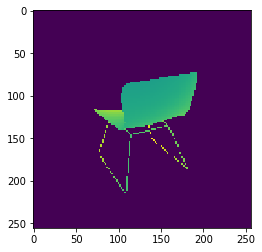

In [16]:
plotImg(depth_img.numpy()[0, 0, :, :])

In [17]:
z = discrete_encoder(depth_img.to(device))
vox_feature = unet(torch.sigmoid(discrete_decoder(mapping(z))))

vox_size = 32

# stay with cpu for v-ram efficiency
sample_pt_normalized = sample_pt + torch.tensor([0.5, 0.5, 0.5])
# (0, 63)
sample_pt_scale = torch.clamp(sample_pt_normalized* (vox_size-1), 0, (vox_size-1)-1e-5)
# (0, 62]
sample_pt_query = torch.clamp((sample_pt_scale).int(), 0, (vox_size-2))
sample_pt_distance = sample_pt_scale - sample_pt_query

context = getContext(sample_pt_query, vox_feature)

dx = sample_pt_distance[:, :, 0].unsqueeze(1)
dy = sample_pt_distance[:, :, 1].unsqueeze(1)
dz = sample_pt_distance[:, :, 2].unsqueeze(1)
# local feature
con = trilinearInterpolation(context, dx, dy, dz)

sample_pt_batch = sample_pt.transpose(-1, -2).to(device)
con_batch = con.to(device)
z_batch = z.squeeze(-1).squeeze(-1).repeat(1, 1, sample_size)
sample_sdf_batch = sample_sdf.transpose(-1, -2).to(device)

In [21]:
sample_pt_batch = sample_pt_batch.transpose(-1, -2).reshape(-1, 3)
con_batch = con_batch.transpose(-1, -2).reshape(-1, 32)
z_batch = z_batch.transpose(-1, -2).reshape(-1, 256)
sample_sdf_batch = sample_sdf_batch.transpose(-1, -2).reshape(-1, 1)

In [23]:
pred_sdf = continuous(sample_pt_batch, con_batch, z_batch)

In [24]:
pred_sdf = torch.sign(pred_sdf)*torch.pow(pred_sdf, 4)

In [25]:
vox_size = 32

# convert sdf to voxel
def sdf2Voxel(sample_pt, sample_sdf_val, fill = 0):
    
    sample_pt = ((sample_pt + np.array([0.5, 0.5, 0.5]))* vox_size).astype(int)
    sample_pt = np.clip(sample_pt, 0, vox_size-1)
    
    v = fill * np.ones((vox_size, vox_size, vox_size))
    v[sample_pt[:,0], sample_pt[:,1], sample_pt[:,2]] = sample_sdf_val
    
    return v

In [26]:
vox_from_predict_occ = sdf2Voxel(sample_pt.reshape(-1, 3).detach().cpu().numpy(), pred_sdf.reshape(-1,).detach().cpu().numpy(), fill = 1)

<IPython.core.display.Javascript object>


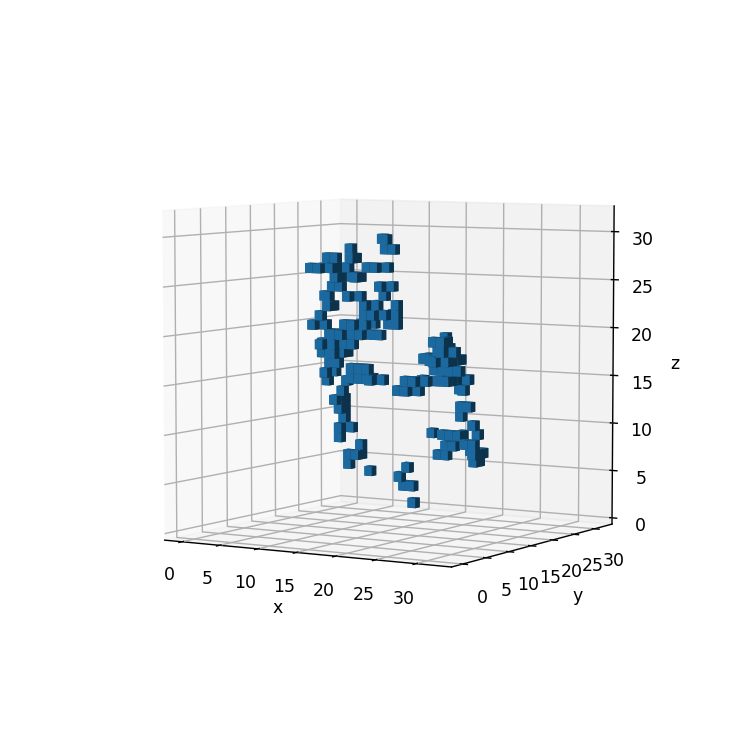

In [27]:
%matplotlib notebook

plotFromVoxels(vox_from_predict_occ < 0)

In [36]:
vox_from_predict_occ.shape

(64, 64, 64)

In [17]:
import skimage.measure as sk
import pymesh
import pyrender
import trimesh

verts, faces, _, _ =  sk.marching_cubes_lewiner(vox_from_predict_occ, level=0)
    
mesh = pymesh.form_mesh(verts, faces)
dis_meshes = pymesh.separate_mesh(mesh, connectivity_type='auto')
    
max_vertices = 0
current_i = 0
for i in range(len(dis_meshes)):

    if dis_meshes[i].vertices.shape[0] > max_vertices:
        max_vertices = dis_meshes[i].vertices.shape[0]
        current_i = i
    
mesh = dis_meshes[current_i]
mesh = trimesh.Trimesh(mesh.vertices,mesh.faces)
mesh_py = pyrender.Mesh.from_trimesh(mesh)
scene = pyrender.Scene()
scene.add(mesh_py)
viewer = pyrender.Viewer(scene, use_raymond_lighting=True, point_size=2)

NameError: name 'vox_from_predict_occ' is not defined

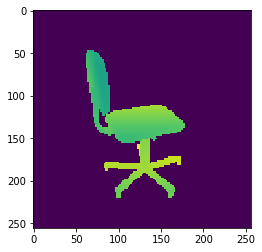

In [18]:
idx = 4

data = train_sdf_dataset[16*24*idx]
depth_img = data['depth_img'].unsqueeze(0)
plotImg(depth_img.numpy()[0, 0, :, :])

In [20]:
z = mapping(discrete_encoder(depth_img.to(device)))
vox_feature = unet(torch.sigmoid(discrete_decoder(mapping(z))))

#vox_feature = unet(data['target_vox'].unsqueeze(0).to(device))

In [21]:
vox_feature.shape

torch.Size([1, 32, 32, 32, 32])

In [22]:
vox_res = 32
grid_res = 64

vox = np.zeros((grid_res, grid_res, grid_res))
idx = np.array(np.where(vox == 0))
    
# normalize
sample_pt = (torch.t(torch.tensor(idx/grid_res, dtype=torch.float)) - 0.5)
sample_pt = sample_pt.reshape(-1, sample_size, 3)

batch_size, sample_size, _ = sample_pt.shape

In [23]:
vox_feature = vox_feature.repeat(batch_size, 1, 1, 1, 1)

In [24]:
vox_feature.shape

torch.Size([128, 32, 32, 32, 32])

In [25]:
# stay with cpu for v-ram efficiency
sample_pt_normalized = sample_pt + torch.tensor([0.5, 0.5, 0.5])
# (0, 63)
sample_pt_scale = torch.clamp(sample_pt_normalized* (vox_res-1), 0, (vox_res-1)-1e-5)
# (0, 62]
sample_pt_query = torch.clamp((sample_pt_scale).int(), 0, (vox_res-2))
sample_pt_distance = sample_pt_scale - sample_pt_query

context = getContext(sample_pt_query, vox_feature)

dx = sample_pt_distance[:, :, 0].unsqueeze(1)
dy = sample_pt_distance[:, :, 1].unsqueeze(1)
dz = sample_pt_distance[:, :, 2].unsqueeze(1)
# local feature
con = trilinearInterpolation(context, dx, dy, dz)

sample_pt_batch = sample_pt.transpose(-1, -2).to(device)
con_batch = con.to(device)
z_batch = z.squeeze(-1).squeeze(-1).repeat(batch_size, 1, sample_size)

In [26]:
sample_pt_batch = sample_pt_batch.transpose(-1, -2).reshape(-1, 3)
con_batch = con_batch.transpose(-1, -2).reshape(-1, 32)
z_batch = z_batch.transpose(-1, -2).reshape(-1, 256)

In [27]:
pred_sdf = continuous(sample_pt_batch, con_batch, z_batch)

In [28]:
pred_sdf.shape

torch.Size([262144, 1])

In [29]:
idx.shape

(3, 262144)

In [30]:
vox[tuple([idx[0], idx[1], idx[2]])] = pred_sdf[:, 0].detach().cpu().numpy()

<IPython.core.display.Javascript object>


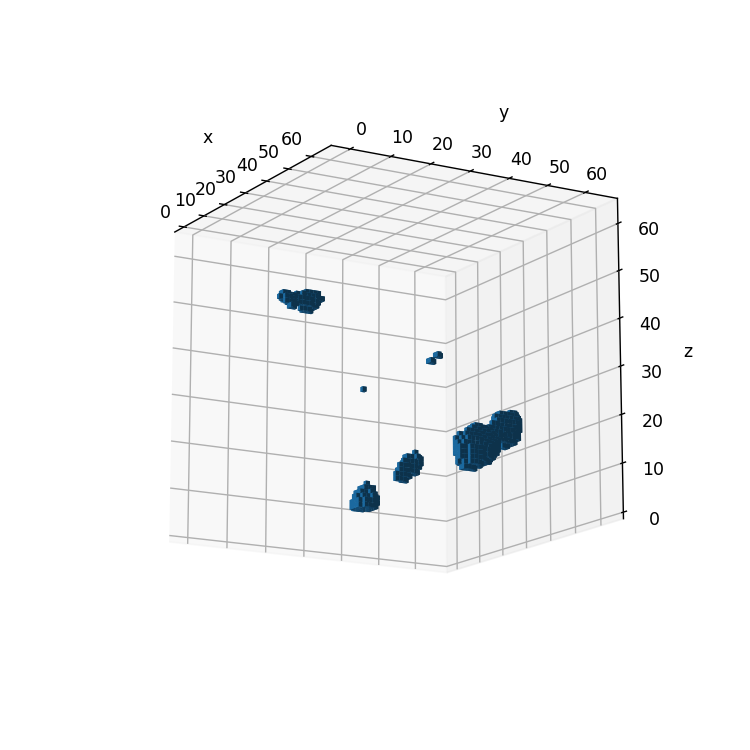

In [31]:
%matplotlib notebook

plotFromVoxels(vox < 0)

In [32]:
import skimage.measure as sk

import pymesh
import pyrender
import trimesh

verts, faces, _, _ =  sk.marching_cubes_lewiner(vox, level=0)

mesh = pymesh.form_mesh(verts, faces)
# dis_meshes = pymesh.separate_mesh(mesh, connectivity_type='auto')

# max_vertices = 0
# current_i = 0
# for i in range(len(dis_meshes)):

#     if dis_meshes[i].vertices.shape[0] > max_vertices:
#         max_vertices = dis_meshes[i].vertices.shape[0]
#         current_i = i

# mesh = dis_meshes[current_i]
mesh = trimesh.Trimesh(mesh.vertices,mesh.faces)
trimesh.repair.fix_inversion(mesh)
mesh_py = pyrender.Mesh.from_trimesh(mesh)
scene = pyrender.Scene()
scene.add(mesh_py)
viewer = pyrender.Viewer(scene, use_raymond_lighting=True, point_size=2)